# Efficient Embeddings Generation

## Overview

This notebook demonstrates techniques for efficiently generating embeddings at scale through:

1. **Batching**: Processing multiple inputs together rather than one at a time
2. **Caching**: Storing previously generated embeddings to avoid regeneration

These optimization strategies can significantly improve performance in production systems that rely on embeddings for natural language processing tasks.

## Setup

First, let's install the required packages:

In [9]:
# Install the required packages (only run this once)
!uv pip install accelerate==1.6.0 sentence-transformers==4.0.2

Using Python 3.12.9 environment at: /workspaces/fundamentals-of-ai-engineering-principles-and-practical-applications-6026542/.venv
Audited 2 packages in 24ms


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Now, let's import the necessary libraries and set up our environment:

In [10]:
from sentence_transformers import SentenceTransformer
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import hashlib
from functools import lru_cache
import pandas as pd

# Load model - using a lightweight model suitable for demonstration
model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

# Generate example sentences for benchmarking
sentences = [
    f"This is a sample sentence for benchmarking embeddings generation {i}."
    for i in range(1000)
]

print(f"Created {len(sentences)} example sentences")

Created 1000 example sentences


## Impact of Batch Size on Performance

Batching is a crucial optimization technique. Instead of processing each input one by one, we process multiple inputs together. This maximizes computational efficiency, especially with GPU acceleration. Let's analyze how different batch sizes affect:

- **Throughput**: How many embeddings we can generate per second
- **Latency**: How much time each batch takes to process

In [ ]:
# Measure impact of batch size on throughput and latency
batch_sizes = [1, 4, 8, 16, 32, 64, 128, 256]
results = []

print("Measuring impact of batch size on throughput and latency...")

for batch_size in tqdm(batch_sizes):
    start_time = time.time()

    # Process data in batches
    embeddings = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        batch_embeddings = model.encode(batch)
        embeddings.extend(batch_embeddings)

    # Calculate metrics
    total_time = time.time() - start_time
    throughput = len(sentences) / total_time
    avg_latency = total_time / (len(sentences) / batch_size)

    results.append({
        'Batch Size': batch_size,
        'Total Time (s)': total_time,
        'Throughput (samples/s)': throughput,
        'Avg Batch Latency (s)': avg_latency
    })

# Convert to DataFrame
df = pd.DataFrame(results)
print(df)

Let's visualize the relationship between batch size and performance:

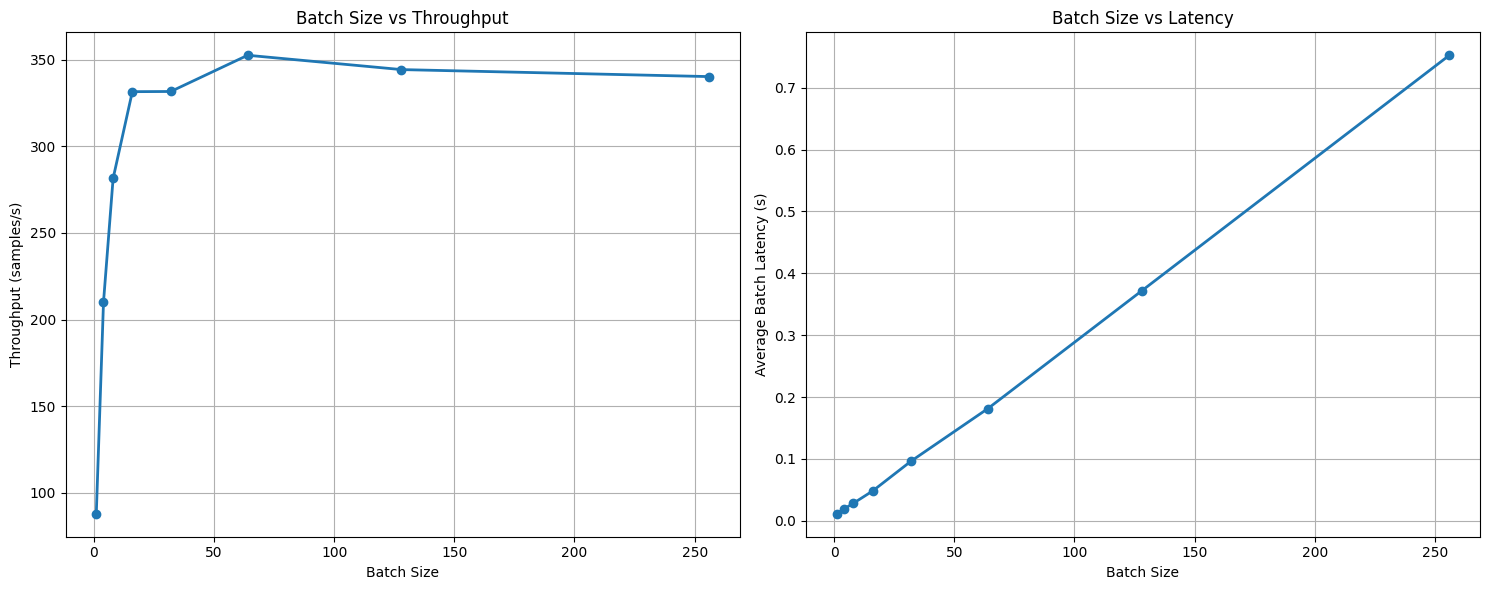

In [11]:
# Visualize the results
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(df['Batch Size'], df['Throughput (samples/s)'], 'o-', linewidth=2)
plt.xlabel('Batch Size')
plt.ylabel('Throughput (samples/s)')
plt.title('Batch Size vs Throughput')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df['Batch Size'], df['Avg Batch Latency (s)'], 'o-', linewidth=2)
plt.xlabel('Batch Size')
plt.ylabel('Average Batch Latency (s)')
plt.title('Batch Size vs Latency')
plt.grid(True)

plt.tight_layout()
plt.show()

### Key Observations:

1. **Throughput Increases with Batch Size**: As we increase the batch size, we can generate more embeddings per second up to a certain point.

2. **Diminishing Returns**: Beyond a certain batch size (usually around 32-64), the throughput gains tend to plateau or even decrease due to memory limitations.

3. **Latency Trade-off**: While larger batches improve throughput, they increase the average time to process each batch, which may be important for real-time applications.

4. **Batch Size Selection**: The optimal batch size depends on your specific requirements:
   - For real-time applications: Smaller batches (lower latency)
   - For bulk processing jobs: Larger batches (higher throughput)

## Part 2: Implementing Embedding Caches

In many real-world applications, we often encounter the same text multiple times. Caching the embeddings can avoid redundant computation and significantly improve performance.

### Simple Dictionary-Based Cache

In [12]:
class SimpleEmbeddingCache:
    def __init__(self, model):
        self.model = model
        self.cache = {}  # Dictionary that maps text to embeddings
        self.hits = 0    # Counter for cache hits
        self.misses = 0  # Counter for cache misses

    def _get_hash(self, text):
        """Generate a stable hash for a text string"""
        return hashlib.md5(text.encode('utf-8')).hexdigest()

    def encode(self, texts, batch_size=32):
        """Encode texts using cache when available"""
        results = []
        texts_to_encode = []
        text_indices = []

        # Check cache for each text
        for i, text in enumerate(texts):
            text_hash = self._get_hash(text)
            if text_hash in self.cache:
                results.append((i, self.cache[text_hash]))
                self.hits += 1
            else:
                texts_to_encode.append(text)
                text_indices.append(i)
                self.misses += 1

        # Generate embeddings for cache misses
        if texts_to_encode:
            # Process in batches
            new_embeddings = []
            for i in range(0, len(texts_to_encode), batch_size):
                batch = texts_to_encode[i:i+batch_size]
                batch_embeddings = model.encode(batch)
                new_embeddings.extend(batch_embeddings)

            # Update cache with new embeddings
            for i, text in enumerate(texts_to_encode):
                text_hash = self._get_hash(text)
                self.cache[text_hash] = new_embeddings[i]
                results.append((text_indices[i], new_embeddings[i]))

        # Sort by original index and extract embeddings
        results.sort(key=lambda x: x[0])
        return np.array([emb for _, emb in results])

    def get_stats(self):
        """Return cache performance statistics"""
        total = self.hits + self.misses
        hit_rate = self.hits / total if total > 0 else 0
        return {
            "hits": self.hits,
            "misses": self.misses,
            "total": total,
            "hit_rate": hit_rate
        }

### LRU Cache-Based Implementation

Python's built-in `functools.lru_cache` provides a convenient way to implement a Least Recently Used (LRU) cache, which automatically evicts the least recently used items when the cache reaches its size limit.

In [13]:
@lru_cache(maxsize=1024)
def hash_text(text):
    return hashlib.md5(text.encode('utf-8')).hexdigest()

class LRUEmbeddingCache:
    def __init__(self, model, maxsize=1024):
        self.model = model
        self.encode_single = lru_cache(maxsize=maxsize)(self._encode_single)
        self.hits = 0
        self.misses = 0
        self.hash_to_text = {}

    def _encode_single(self, text_hash):
        """Generate embedding for a single text (identified by hash)"""
        self.misses += 1
        # Convert hash back to the original text
        text = self.hash_to_text[text_hash]
        return self.model.encode([text])[0]  # Note: we're encoding a single text

    def encode(self, texts, batch_size=32):
        """Encode texts using LRU cache when available"""
        self.hash_to_text = {}
        results = []

        for text in texts:
            # Use the hash as the cache key
            text_hash = hash_text(text)
            self.hash_to_text[text_hash] = text

            # Check if it's in the cache
            cache_info_before = self.encode_single.cache_info()
            embedding = self.encode_single(text_hash)
            cache_info_after = self.encode_single.cache_info()
            
            # Update hit/miss counters
            if cache_info_after.hits > cache_info_before.hits:
                self.hits += 1
                
            results.append(embedding)

        return np.array(results)

    def get_stats(self):
        """Return cache performance statistics"""
        total = self.hits + self.misses
        hit_rate = self.hits / total if total > 0 else 0
        return {
            "hits": self.hits,
            "misses": self.misses,
            "total": total,
            "hit_rate": hit_rate,
            "cache_info": self.encode_single.cache_info()
        }

## Evaluating Cache Performance

Let's compare the performance with and without caching:

In [14]:
# Create a test dataset with some repetition to demonstrate cache benefits
print("\nDemonstrating caching benefits:")
test_data = []
for i in range(500):
    # Every 5th sentence is repeated from the first 100 sentences
    test_data.append(sentences[i % 100] if i % 5 == 0 else sentences[i])
print(f"Test data size: {len(test_data)} sentences")

# Benchmark 1: Without cache
print("\n1. Without cache:")
start = time.time()
embeddings_no_cache = model.encode(test_data, batch_size=32)
no_cache_time = time.time() - start
print(f"Processing time: {no_cache_time:.4f}s")

# Benchmark 2: First run with cache (should be all misses)
print("\n2. First run with cache:")
cache = SimpleEmbeddingCache(model)
start = time.time()
embeddings_with_cache = cache.encode(test_data, batch_size=32)
first_run_time = time.time() - start
print(f"Processing time: {first_run_time:.4f}s")
print(
    f"Cache stats: {cache.hits} hits, {cache.misses} misses ({cache.hits/len(test_data)*100:.1f}% hit rate)")

# Benchmark 3: Second run with fresh cache object but reusing the populated cache dictionary
print("\n3. Second run with cache (should be all hits):")
# Create a new cache instance but reuse the cache dictionary from the first run
second_cache = SimpleEmbeddingCache(model)
second_cache.cache = cache.cache  # Copy the populated cache from first run
start = time.time()
embeddings_with_cache = second_cache.encode(test_data, batch_size=32)
second_run_time = time.time() - start
print(f"Processing time: {second_run_time:.4f}s")
print(f"Cache stats: {second_cache.hits} hits, {second_cache.misses} misses ({second_cache.hits/len(test_data)*100:.1f}% hit rate)")

# Performance summary
print("\nPerformance summary:")
print(f"- Without cache: {no_cache_time:.4f}s")
print(f"- First run with cache: {first_run_time:.4f}s")
print(f"- Second run with cache: {second_run_time:.4f}s")
print(
    f"- Speed improvement: {no_cache_time/second_run_time:.1f}x faster with cache")


Demonstrating caching benefits:
Test data size: 500 sentences

1. Without cache:
Processing time: 1.4586s

2. First run with cache:
Processing time: 1.4052s
Cache stats: 0 hits, 500 misses (0.0% hit rate)

3. Second run with cache (should be all hits):
Processing time: 0.0015s
Cache stats: 500 hits, 0 misses (100.0% hit rate)

Performance summary:
- Without cache: 1.4586s
- First run with cache: 1.4052s
- Second run with cache: 0.0015s
- Speed improvement: 956.8x faster with cache


## Conclusion

Efficient embedding generation is critical for building performant AI applications. 

By implementing batching and caching strategies, you can significantly improve throughput and reduce latency, especially in production 

environments with repetitive content or high-volume processing needs.

The specific optimization strategy depends on your application's requirements:
- **Latency-sensitive applications**: Focus on smaller batch sizes and efficient caching
- **High-throughput batch processing**: Use larger batch sizes and persistent caches
- **Mixed workloads**: Implement adaptive strategies with priority queues
